In [9]:
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
# !pip install scikit-learn

     ---------------------------------------- 7.4/7.4 MB 21.5 MB/s eta 0:00:00
     --------------------------------------- 38.6/38.6 MB 23.4 MB/s eta 0:00:00
     ------------------------------------- 298.0/298.0 KB 19.2 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\user\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [17]:
df = pd.read_csv('kospi.csv', encoding='cp949')
df

,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,상장시가총액
0,2022/09/19,2360.43,-22.35,-0.94,2388.73,2389.85,2356.99,226042.0,3902965.0,1.860463e+09
1,2022/09/16,2382.78,-19.05,-0.79,2387.56,2395.10,2371.11,440799.0,8690464.0,1.877514e+09
2,2022/09/15,2401.83,-9.59,-0.40,2416.01,2421.63,2401.83,424111.0,7432764.0,1.892387e+09
3,2022/09/14,2411.42,-38.12,-1.56,2390.47,2418.42,2381.50,461508.0,7625505.0,1.900213e+09
4,2022/09/13,2449.54,65.26,2.74,2418.59,2453.95,2418.59,367103.0,9165153.0,1.930515e+09
...,...,...,...,...,...,...,...,...,...,...
240,2021/09/28,3097.92,-35.72,-1.14,3133.40,3134.46,3095.72,894913.0,14658731.0,2.254316e+09
241,2021/09/27,3133.64,8.40,0.27,3121.70,3146.35,3119.26,883229.0,12266967.0,2.279895e+09
242,2021/09/24,3125.24,-2.34,-0.07,3140.73,3146.86,3119.40,753222.0,12558236.0,2.273591e+09
243,2021/09/23,3127.58,-12.93,-0.41,3123.64,3131.63,3107.98,623841.0,14009138.0,2.275325e+09


In [18]:
scaler = MinMaxScaler()
scaled_col = [col for col in df.columns if col != '일자']
df[scaled_col] = scaler.fit_transform(df[scaled_col])

In [19]:
df.head(5)

,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,상장시가총액
0,2022/09/19,0.080636,0.452472,0.412141,0.095893,0.086344,0.095352,0.000000,0.000000,0.117097
1,2022/09/16,0.106977,0.473095,0.436102,0.094486,0.092680,0.112107,0.142200,0.287609,0.152602
2,2022/09/15,0.129428,0.532217,0.498403,0.128691,0.124700,0.148558,0.131151,0.212053,0.183570
3,2022/09/14,0.140731,0.353915,0.313099,0.097985,0.120826,0.124435,0.155913,0.223631,0.199865
4,2022/09/13,0.185657,1.000000,1.000000,0.131793,0.163708,0.168445,0.093403,0.316126,0.262961


In [20]:
X = df[["시가","고가","저가","종가"]].values
y = df["종가"].values

In [21]:
X.shape

(245, 4)

In [24]:
y.shape


(245,)

In [26]:
def sequence_data(X,y,sequence_size):
    x_seq = []
    y_seq = []
    for idx in range(len(X) - sequence_size):
        x_seq.append(X[idx:idx + sequence_size])
        y_seq.append(y[idx + sequence_size])
        
    return torch.tensor(x_seq,dtype=torch.float32), torch.tensor(y_seq,dtype=torch.float32).view(-1,1)

In [27]:
split = 200
sequence_length =5
X_seq, y_seq = sequence_data(X,y,sequence_length)

X_train_seq = X_seq[:split]
y_train_seq = y_seq[:split]
X_test_seq = X_seq[split:]
y_test_seq = y_seq[split:]

C:\Users\user\AppData\Local\Temp\ipykernel_16412\2067386187.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  return torch.tensor(x_seq,dtype=torch.float32), torch.tensor(y_seq,dtype=torch.float32).view(-1,1)


In [29]:
from torch.utils.data import TensorDataset

In [31]:
train_set = TensorDataset(X_train_seq, y_train_seq)
test_set = TensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

In [32]:
input_size = X_seq.size(2)
num_layers= 2
hidden_size = 8

In [33]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(LSTM,self).__init__()
        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, 1)
        
    def forward(self , x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        
        out, _ = self.lstm(x, (h0,c0))
        out = out.reshape(out.shape[0],-1)
        out = self.fc(out)
        return out

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_size, hidden_size, 5, num_layers, device).to(device)

criterion = nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=1e-3)

loss_graph = []
n = len(train_loader)

for epoch in range(50):
    running_loss = 0.
    for data in train_loader:
        seq, target = data[0].to(device), data[1].to(device)
        
        out = model(seq)
        loss = criterion(out,target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print("[epoch: %d] loss: %.4f" %(epoch,running_loss/n))

[epoch: 0] loss: 0.1284
[epoch: 10] loss: 0.0083
[epoch: 20] loss: 0.0031
[epoch: 30] loss: 0.0028
[epoch: 40] loss: 0.0027


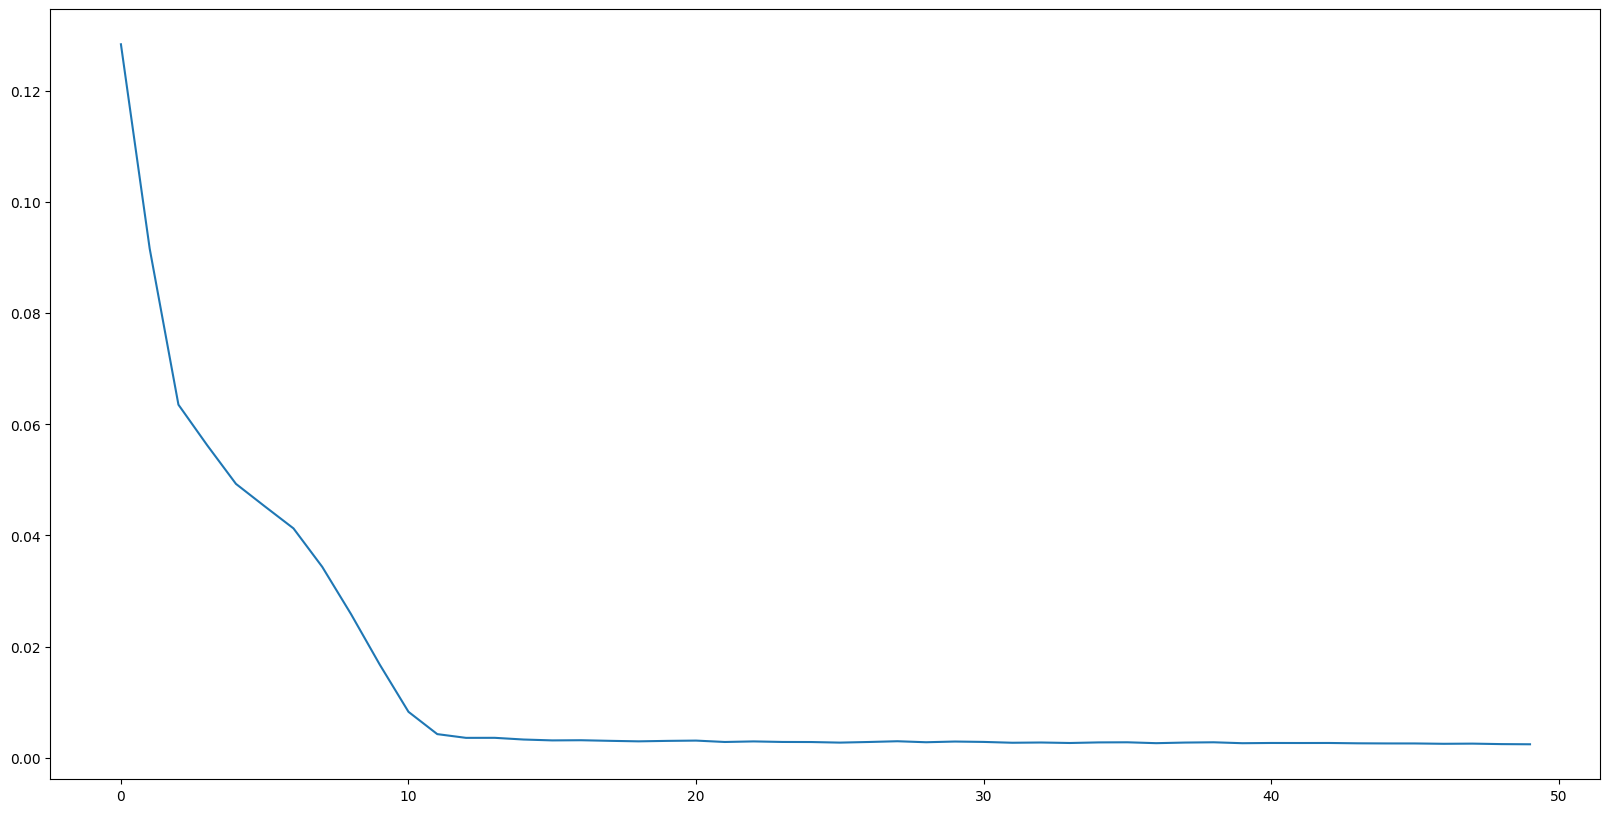

In [38]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

# 예측값과 실제값을 비교

In [39]:
concatdata = torch.utils.data.ConcatDataset([train_set,test_set])
data_loader = DataLoader(dataset=concatdata, batch_size=16)

model.eval()
with torch.no_grad():
    pred = []
    for data in data_loader:
        seq, target = data[0].to(device), data[1].to(device)
        out = model(seq)
        pred += out.cpu().tolist()

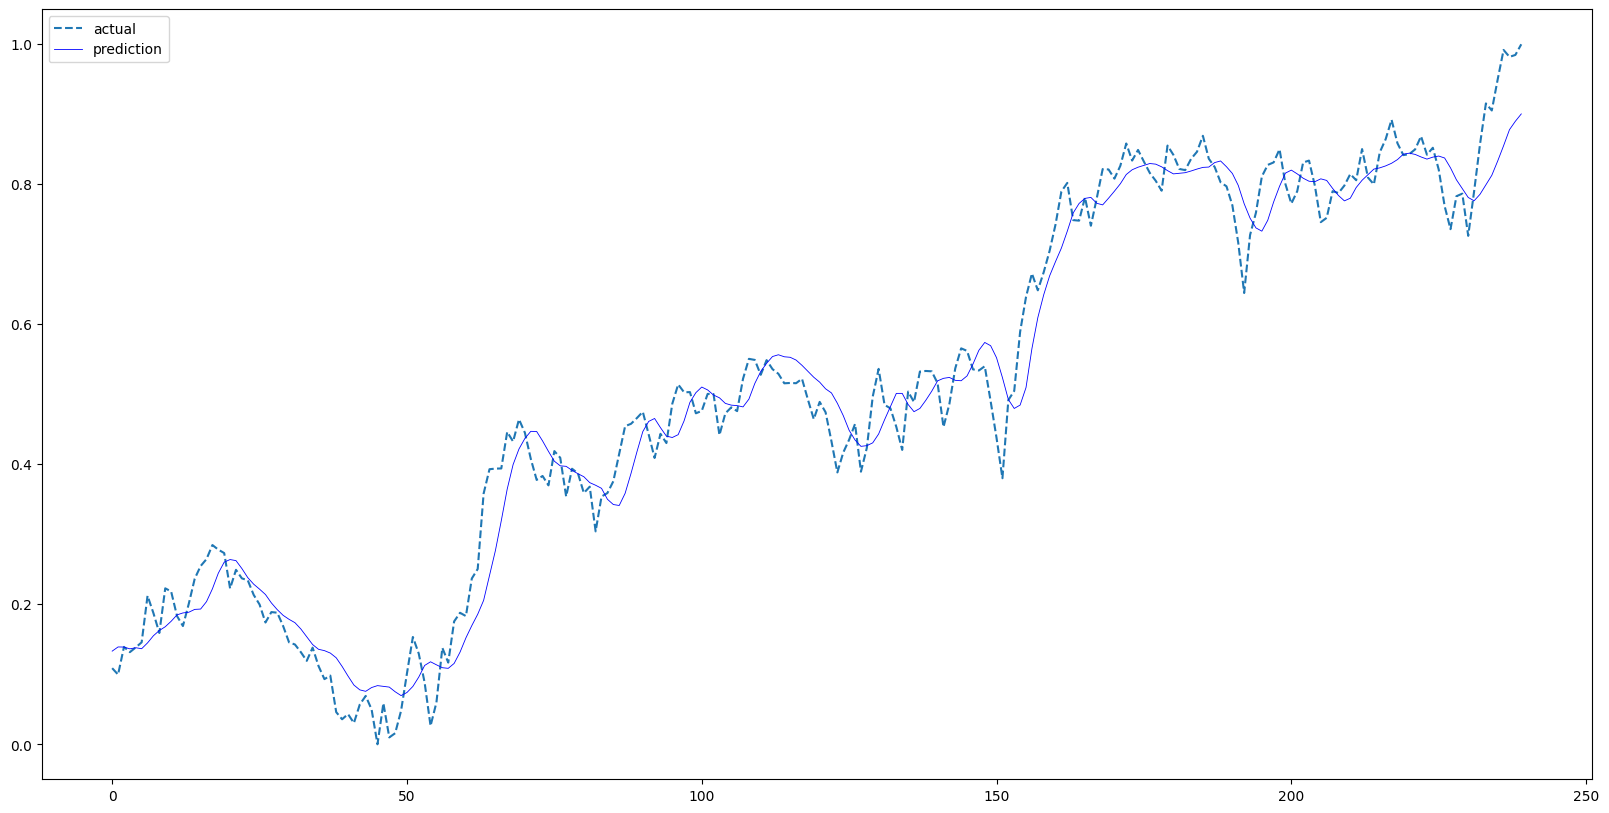

In [40]:
plt.figure(figsize=(20,10))
plt.plot(df['종가'][sequence_length:].values, '--')
plt.plot(pred, 'b', linewidth=0.6)
plt.legend(['actual','prediction'])

plt.show()